# Prediction from densenet embeddings

Input: 
- csv with disease labels + embeddings extracted using the densenet torch x ray vision model  

Do:  
- train a neural network multiclass classifier to predict the diseases  
- assess bias  

In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import wandb


### Read the CSV

In [6]:
# test = pd.read_csv("../model_dev/densenet_data/densenet_all_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
# train = pd.read_csv("../model_dev/densenet_data/densenet_all_train_embeddings.csv", quotechar='"', on_bad_lines='skip')
# valid = pd.read_csv("../model_dev/densenet_data/densenet_all_valid_embeddings.csv", quotechar='"', on_bad_lines='skip')

test_initial = pd.read_csv("../model_dev/densenet_data/densenet_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
train_initial = pd.read_csv("../model_dev/densenet_data/densenet_train_embeddings.csv", quotechar='"', on_bad_lines='skip')
valid_initial = pd.read_csv("../model_dev/densenet_data/densenet_valid_embeddings.csv", quotechar='"', on_bad_lines='skip')

print(test_initial.columns)
test_initial.head()

Index(['path_to_image', 'path_to_dcm', 'age', 'sex', 'race', 'insurance_type',
       'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'embeddings'],
      dtype='object')


,path_to_image,path_to_dcm,age,sex,race,insurance_type,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,embeddings
0,train/patient47347/study3/view1_frontal.jpg,train/patient47347/study3/view1_frontal.dcm,78.0,1,0,1,0,0,1,0,...,1,0,0,1,0,1,0,1,1,"[0.0029132624622434378, 0.1020001769065857, 0...."
1,train/patient37527/study12/view1_frontal.jpg,train/patient37527/study12/view1_frontal.dcm,63.0,0,1,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"[0.0014348188415169716, 0.0543656125664711, 0...."
2,train/patient41208/study9/view1_frontal.jpg,train/patient41208/study9/view1_frontal.dcm,70.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0.001982336398214102, 0.040021587163209915, 0..."
3,train/patient39357/study1/view1_frontal.jpg,train/patient39357/study1/view1_frontal.dcm,79.0,1,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"[0.001741771469824016, 0.0560498870909214, 0.1..."
4,train/patient31982/study4/view1_frontal.jpg,train/patient31982/study4/view1_frontal.dcm,67.0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,"[9.678312198957428e-05, 0.12247737497091293, 0..."


### Convert embeddings from str to list (a bit long for large data sets)

In [7]:
test_initial['embeddings'] = test_initial['embeddings'].apply(ast.literal_eval)

In [8]:
valid_initial['embeddings'] = valid_initial['embeddings'].apply(ast.literal_eval)

In [9]:
train_initial['embeddings'] = train_initial['embeddings'].apply(ast.literal_eval)

### Remove columns

In [10]:
test = test_initial.drop(columns=['path_to_image', 'path_to_dcm'])
train = train_initial.drop(columns=['path_to_image', 'path_to_dcm'])
valid = valid_initial.drop(columns=['path_to_image', 'path_to_dcm'])


### Remove rows that were not processed (embeddings = 0)

In [11]:
initial_size = test.shape[0] 
test = test[test['embeddings'].str.len() > 10]
final_size = test.shape[0] 
print(f'Number of test removed rows = {initial_size - final_size}')

initial_size = train.shape[0] 
train = train[train['embeddings'].str.len() > 10]
final_size = train.shape[0] 
print(f'Number of train removed rows = {initial_size - final_size}')

initial_size = test.shape[0] 
valid = valid[valid['embeddings'].str.len() > 10]
final_size = test.shape[0] 
print(f'Number of valid removed rows = {initial_size - final_size}')

Number of test removed rows = 51
Number of train removed rows = 67
Number of valid removed rows = 0


### Create artificial training distribution

In [12]:
print("Initial sex Distribution:")
print(train['sex'].value_counts())

print("\nInitial Race Distribution:")
print(train['race'].value_counts())

Initial sex Distribution:
sex
0    38998
1    28198
Name: count, dtype: int64

Initial Race Distribution:
race
0    52553
1     9844
2     4799
Name: count, dtype: int64


In [13]:
nb_of_rows_to_remove = 0
cath_to_remove = 'sex' # sex or race
which_cath = 1 # 0 or 1 or 2

filtered_df = train[train[cath_to_remove] == which_cath]

rows_to_drop = filtered_df.sample(n=nb_of_rows_to_remove, random_state=42) 

train = train.drop(rows_to_drop.index)

print("\nFinal sex Distribution:")
print(train['sex'].value_counts())

print("\nFinal Race Distribution:")
print(train['race'].value_counts())


Final sex Distribution:
sex
0    38998
1    28198
Name: count, dtype: int64

Final Race Distribution:
race
0    52553
1     9844
2     4799
Name: count, dtype: int64


### Visualize distribution of diseases

In [14]:
col = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
            'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'No Finding']

print(f"Distribution in train set")
for disease in col:
    counts = train[disease].value_counts()
    print(f"{disease}: - 0s: {counts.get(0, 0)}, 1s: {counts.get(1, 0)}")
print(f"Distribution in test set")
for disease in col:
    counts = test[disease].value_counts()
    print(f"{disease}:- 0s: {counts.get(0, 0)}, 1s: {counts.get(1, 0)}")


Distribution of Enlarged Cardiomediastinum in train set: - 0s: 63738, 1s: 3458
Distribution of Cardiomegaly in train set: - 0s: 58986, 1s: 8210
Distribution of Lung Opacity in train set: - 0s: 33926, 1s: 33270
Distribution of Lung Lesion in train set: - 0s: 64703, 1s: 2493
Distribution of Edema in train set: - 0s: 51202, 1s: 15994
Distribution of Consolidation in train set: - 0s: 62851, 1s: 4345
Distribution of Pneumonia in train set: - 0s: 65571, 1s: 1625
Distribution of Atelectasis in train set: - 0s: 57067, 1s: 10129
Distribution of Pneumothorax in train set: - 0s: 60688, 1s: 6508
Distribution of Pleural Effusion in train set: - 0s: 40484, 1s: 26712
Distribution of Pleural Other in train set: - 0s: 66251, 1s: 945
Distribution of Fracture in train set: - 0s: 64485, 1s: 2711
Distribution of No Finding in train set: - 0s: 61107, 1s: 6089

Distribution of Enlarged Cardiomediastinum in test set:- 0s: 38350, 1s: 1957
Distribution of Cardiomegaly in test set:- 0s: 35347, 1s: 4960
Distribut

### Train evaluate test

In [15]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: cmottez (cmottez-stanford-university). Use `wandb login --relogin` to force relogin


True

In [16]:
# Initialize a new run
wandb.init(project='test_bias', entity='cmottez-stanford-university')

In [36]:
train_embeddings = pd.DataFrame(train['embeddings'].tolist())
test_embeddings = pd.DataFrame(test['embeddings'].tolist())
valid_embeddings = pd.DataFrame(valid['embeddings'].tolist())

# Diseases to predict
# diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
#             'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']

# Labels for train and test
y_train = train[diseases]
y_test = test[diseases]
y_valid = valid[diseases]
y_no_finding = test["No Finding"]
y_sex = test['sex']
y_race = test['race']

In [37]:
learning_rate = 0.001
weight_decay = 1e-7
dropout = 0.2
batch_size = 64

In [38]:
# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data - Convert dataframes to tensors and create dataloaders
X_train = torch.tensor(train_embeddings.values).float().to(device)
y_train = torch.tensor(y_train.values).float().to(device)
X_test = torch.tensor(test_embeddings.values).float().to(device)
y_test = torch.tensor(y_test.values).float().to(device)
X_valid = torch.tensor(valid_embeddings.values).float().to(device)
y_valid = torch.tensor(y_valid.values).float().to(device)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
valid_data = TensorDataset(X_valid, y_valid)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)



In [39]:
# Define the neural network
class MultiLabelNN(nn.Module):
    def __init__(self, input_size, output_size, dropout):
        super(MultiLabelNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, output_size)  # Output layer size = number of diseases
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout) 

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [40]:
model = MultiLabelNN(1024, len(diseases), dropout).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [41]:
# Training the model with loss reporting and improved visualization
def train_model(train_loader, validation_loader, model, criterion, optimizer, num_epochs):
    model.train()
    training_stats = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_val_loss = 0, 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        training_stats['train_loss'].append(total_loss / len(train_loader))

        # Validation loss calculation
        model.eval()
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss = criterion(output, target)
                total_val_loss += val_loss.item()

        training_stats['val_loss'].append(total_val_loss / len(validation_loader))
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {training_stats["train_loss"][-1]:.4f}, Validation Loss: {training_stats["val_loss"][-1]:.4f}')

        wandb.log({
        'epoch': epoch,
        'training_loss': loss,
        'validation_loss': val_loss,
    })

    return training_stats


Epoch 1/10, Training Loss: 0.4451, Validation Loss: 0.4323
Epoch 2/10, Training Loss: 0.4344, Validation Loss: 0.4314
Epoch 3/10, Training Loss: 0.4320, Validation Loss: 0.4292
Epoch 4/10, Training Loss: 0.4306, Validation Loss: 0.4284
Epoch 5/10, Training Loss: 0.4292, Validation Loss: 0.4283
Epoch 6/10, Training Loss: 0.4275, Validation Loss: 0.4273
Epoch 7/10, Training Loss: 0.4265, Validation Loss: 0.4263
Epoch 8/10, Training Loss: 0.4252, Validation Loss: 0.4260
Epoch 9/10, Training Loss: 0.4242, Validation Loss: 0.4251
Epoch 10/10, Training Loss: 0.4234, Validation Loss: 0.4262


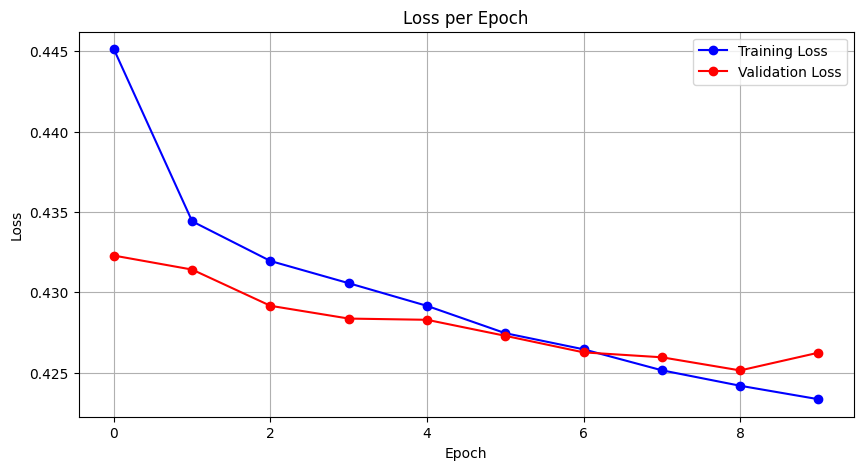

In [42]:
# Run training
nb_epoch = 10
stats = train_model(train_loader, valid_loader, model, criterion, optimizer, nb_epoch)

# Plotting the training and validation loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(stats['train_loss'], marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(stats['val_loss'], marker='o', linestyle='-', color='red', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [43]:
# Function to evaluate the model
def evaluate_model(loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            predicted = torch.sigmoid(output).cpu().numpy()
            all_preds.append(predicted)
            all_targets.append(target.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    return all_preds, all_targets

In [44]:
# Evaluate on test data
predictions, targets = evaluate_model(test_loader)

# Create the no finding column
updated_predictions = []

for row in predictions:
    # Check if all elements in the row are less than or equal to 0.5
    if np.all(row <= 0.5):
        new_row = np.append(row, 1)
    else:
        new_row = np.append(row, 0)
    updated_predictions.append(new_row)

predictions = np.array(updated_predictions)

updated_targets = []
for target, no_finding_target in zip(targets, y_no_finding):
    new_target = np.append(target, no_finding_target)
    updated_targets.append(new_target)

targets = np.array(updated_targets)



In [45]:
# diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
#             'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'No finding']
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']

In [46]:
def compute_metrics():
    # Calculate metrics for each disease
    metrics = {}
    for idx, disease in enumerate(diseases):
        disease_pred = predictions[:, idx]
        disease_true = targets[:, idx]
        auc_roc = roc_auc_score(disease_true, disease_pred)
        f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
        accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
        tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
        tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        tn_rate = tn / (tn + fp) if (tn + fp) > 0 else 0
        fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
        fp_rate = fp / (tn + fp) if (tn + fp) > 0 else 0
        
        # Calculate Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
        auprc = auc(recall, precision)

        metrics[disease] = {
            'Accuracy': accuracy,
            'AUC': auc_roc,
            'AUPRC': auprc,
            'F1 Score': f1,
            'TP Rate': tp_rate,
            'FN Rate': fn_rate,
            'TN Rate': tn_rate,
            'FP Rate': fp_rate
        }
    return metrics

metrics = compute_metrics()
print(metrics)

TypeError: 'dict' object is not callable

In [35]:
auc = {}

for disease, values in metrics.items():
    for metric, value in values.items():
        if metric == 'AUC':
            auc[disease] = value

auc

{'Cardiomegaly': 0.41807690168125905,
 'Lung Opacity': 0.6476209396184301,
 'Edema': 0.5059838700351449,
 'Atelectasis': 0.21841231789386567,
 'Pneumothorax': 0.2917853073356055,
 'Pleural Effusion': 0.714921194066366}

### Parameters finetuning

In [29]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
weight_decays = [0, 1e-8, 1e-5, 1e-3, 1e-1]
dropouts = [0, 0.2, 0.5, 0.8]
batch_sizes = [32, 64, 128, 256]

learning_rates = [0.001]
weight_decays = [0, 1e-5]
dropouts = [0.2, 0.5, 0.8]
batch_sizes = [32, 128, 256]

In [30]:

def try_parameters(learning_rate, weight_decay, dropout, batch_size, nb_epoch): 

    diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']


    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

    model = MultiLabelNN(1024, len(diseases), dropout).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    stats = train_model(train_loader, valid_loader, model, criterion, optimizer, nb_epoch)

    # Evaluate on test data
    predictions, targets = evaluate_model(test_loader)

    # Create the no finding column
    updated_predictions = []

    for row in predictions:
        # Check if all elements in the row are less than or equal to 0.5
        if np.all(row <= 0.5):
            new_row = np.append(row, 1)
        else:
            new_row = np.append(row, 0)
        updated_predictions.append(new_row)

    predictions = np.array(updated_predictions)

    updated_targets = []
    for target, no_finding_target in zip(targets, y_no_finding):
        new_target = np.append(target, no_finding_target)
        updated_targets.append(new_target)

    targets = np.array(updated_targets)

    metrics = compute_metrics()

    auc = {}

    for disease, values in metrics.items():
        for metric, value in values.items():
            if metric == 'AUC':
                auc[disease] = value

    return stats, auc


def plot_loss(stats):
    plt.figure(figsize=(5, 3))
    plt.plot(stats['train_loss'], marker='o', linestyle='-', color='blue', label='Training Loss')
    plt.plot(stats['val_loss'], marker='o', linestyle='-', color='red', label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

In [31]:
best_param = {'learning_rate': 0,
              'weight_decay': 0,
              'dropout': 0,
              'batch_size': 0}
previous_auc = 0

In [32]:
for learning_rate in learning_rates:
    print(f"Results for learning_rate = {learning_rate}")
    for weight_decay in weight_decays:
        print(f"Results for weight_decay = {weight_decay}")
        for dropout in dropouts:
            print(f"Results for dropout = {dropout}")
            for batch_size in batch_sizes:
                print(f"Results for batch_size = {batch_size}")
                stats, auc = try_parameters(learning_rate, weight_decay, dropout, batch_size, 5)
                print(f"AUC {auc}")
                mean_auc = sum(auc.values()) / len(auc)
                if mean_auc > previous_auc:
                    previous_auc = mean_auc
                    best_auc = auc
                    best_param['learning_rate'] = learning_rate
                    best_param['weight_decay'] = weight_decay
                    best_param['dropout'] = dropout
                    best_param['batch_size'] = batch_size
                    
                # plot_loss(stats)
print(f'best_param: {best_param}')
print(f"best_auc: {best_auc}")

Results for learning_rate = 0.001
Results for weight_decay = 0
Results for dropout = 0.2
Results for batch_size = 32
Epoch 1/5, Training Loss: 0.4443, Validation Loss: 0.4353
Epoch 2/5, Training Loss: 0.4371, Validation Loss: 0.4324
Epoch 3/5, Training Loss: 0.4345, Validation Loss: 0.4313
Epoch 4/5, Training Loss: 0.4323, Validation Loss: 0.4315
Epoch 5/5, Training Loss: 0.4311, Validation Loss: 0.4282


TypeError: compute_metrics() missing 3 required positional arguments: 'predictions', 'targets', and 'diseases'

In [184]:
stats, auc = best_param

{'learning_rate': 0.001, 'weight_decay': 0, 'dropout': 0.2, 'batch_size': 32}

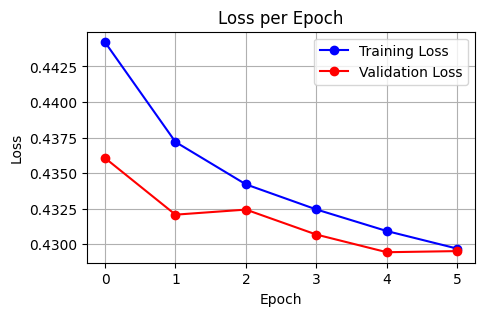

{'Cardiomegaly': 0.8041574568996595,
 'Lung Opacity': 0.6946831463886772,
 'Edema': 0.7871031324484976,
 'Atelectasis': 0.625728880269588,
 'Pneumothorax': 0.7504201994834465,
 'Pleural Effusion': 0.8122826031075887}

In [188]:
stats, auc = try_parameters(0.001, 0, 0.2, 32, 6)
plot_loss(stats)
auc

In [200]:
metrics['Atelectasis']

{'Accuracy': 0.8461805641699953,
 'AUC': 0.625728880269588,
 'F1 Score': 0.0,
 'TP Rate': 0.0,
 'FN Rate': 1.0,
 'TN Rate': 1.0,
 'FP Rate': 0.0}

In [189]:

# Calculate metrics for each disease and for each class

metrics_female = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 1, idx]
    disease_true = targets[y_sex == 1, idx]
    auc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    metrics_female[disease] = {
        'Accuracy': accuracy,
        'AUC': auc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_male = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 0, idx]
    disease_true = targets[y_sex == 0, idx]
    auc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    metrics_male[disease] = {
        'Accuracy': accuracy,
        'AUC': auc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

metrics_white = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 0, idx]
    disease_true = targets[y_race == 0, idx]
    auc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    metrics_white[disease] = {
        'Accuracy': accuracy,
        'AUC': auc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_black = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 2, idx]
    disease_true = targets[y_race == 2, idx]
    auc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    metrics_black[disease] = {
        'Accuracy': accuracy,
        'AUC': auc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_asian = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 1, idx]
    disease_true = targets[y_race == 1, idx]
    auc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    metrics_asian[disease] = {
        'Accuracy': accuracy,
        'AUC': auc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

In [190]:
# Initialize an empty list to store the data
data = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    # Extract AUC and rates from dictionaries
    auc_overall = values['AUC'] *100
    auc_male = metrics_male[disease]['AUC'] *100
    auc_female = metrics_female[disease]['AUC'] *100
    tp_rate_male = metrics_male[disease]['TP Rate'] *100
    tp_rate_female = metrics_female[disease]['TP Rate'] *100
    fp_rate_male = metrics_male[disease]['FP Rate'] *100
    fp_rate_female = metrics_female[disease]['FP Rate'] *100
    
    # Calculate delta AUC and equality of odds
    delta_auc = abs(auc_male - auc_female)
    eq_odds = 0.5 * (abs(tp_rate_male - tp_rate_female) + abs(fp_rate_male - fp_rate_female))
    
    # Append to the data list
    data.append([disease, auc_overall, auc_male, auc_female, delta_auc, eq_odds])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Disease', 'AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds'])


# Styling the DataFrame
styled_df = df.style.format({
    'AUC': "{:.3f}", 
    'AUC_Male': "{:.3f}", 
    'AUC_Female': "{:.3f}",
    'Delta AUC': "{:.3f}",
    'EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds'])

# Display the styled DataFrame
styled_df


,Disease,AUC,AUC_Male,AUC_Female,Delta AUC,EqOdds
0,Cardiomegaly,80.416,80.677,80.112,0.565,0.422
1,Lung Opacity,69.468,69.534,69.412,0.122,1.082
2,Edema,78.710,78.789,78.608,0.182,0.968
3,Atelectasis,62.573,63.242,61.607,1.635,0.000
4,Pneumothorax,75.042,74.375,75.985,1.610,0.189
5,Pleural Effusion,81.228,81.084,81.433,0.348,0.726


In [191]:
# Initialize an empty list to store the data
data = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auc_overall = values['AUC'] *100
    auc_groups = [
        metrics_white[disease]['AUC'] *100,
        metrics_black[disease]['AUC'] *100,
        metrics_asian[disease]['AUC'] *100
    ]
    tp_rates = [
        metrics_white[disease]['TP Rate'] *100,
        metrics_black[disease]['TP Rate'] *100,
        metrics_asian[disease]['TP Rate'] *100
    ]
    fp_rates = [
        metrics_white[disease]['FP Rate'] *100,
        metrics_black[disease]['FP Rate'] *100,
        metrics_asian[disease]['FP Rate'] *100
    ]

    # Calculate the maximum delta AUC
    delta_auc = max(abs(auc_groups[i] - auc_groups[j]) for i in range(len(auc_groups)) for j in range(i + 1, len(auc_groups)))

    # Calculate the maximum equality of odds
    eq_odds = max(
        0.5 * (abs(tp_rates[i] - tp_rates[j]) + abs(fp_rates[i] - fp_rates[j]))
        for i in range(len(tp_rates)) for j in range(i + 1, len(tp_rates))
    )

    # Append to the data list
    data.append([disease, auc_overall] + auc_groups + [delta_auc, eq_odds])

# Create a DataFrame
columns = ['Disease', 'AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds']
df = pd.DataFrame(data, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df.style.format({
    'AUC': "{:.3f}", 
    'AUC_White': "{:.3f}", 
    'AUC_Black': "{:.3f}",
    'AUC_Asian': "{:.3f}",
    'Max Delta AUC': "{:.3f}",
    'Max EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds'])

# Display the styled DataFrame
styled_df

,Disease,AUC,AUC_White,AUC_Black,AUC_Asian,Max Delta AUC,Max EqOdds
0,Cardiomegaly,80.416,79.807,81.835,81.484,2.028,1.266
1,Lung Opacity,69.468,69.153,71.004,70.292,1.850,2.116
2,Edema,78.710,78.710,77.310,79.397,2.087,2.978
3,Atelectasis,62.573,62.708,59.634,62.544,3.075,0.000
4,Pneumothorax,75.042,74.348,78.526,76.880,4.178,0.682
5,Pleural Effusion,81.228,81.053,80.372,82.496,2.124,1.195


### Study a metric

In [192]:
met = 'AUC'  #Accuracy, AUC, F1 Score, TP Rate, FN Rate

In [193]:
# Compute metrics for each disease
auc_general = {}
for disease, values in metrics.items():
    for metric, value in values.items():
        if metric == met:
            auc_general[disease] = value

print(f"General {met}", auc_general)


In [194]:
# Initialize dictionaries to store AUC values
auc_female = {}
auc_male = {}

for disease, values in metrics_female.items():
    for metric, value in values.items():
        if metric == met:
            auc_female[disease] = value

for disease, values in metrics_male.items():
    for metric, value in values.items():
        if metric == met:
            auc_male[disease] = value

# Output results
print(f"{met} for Females: {auc_female}")
print(f"{met} for Males: {auc_male}")


In [195]:
# Initialize dictionaries to store AUC values
auc_white = {}
auc_black = {}
auc_asian = {}

for disease, values in metrics_white.items():
    for metric, value in values.items():
        if metric == met:
            auc_white[disease] = value

for disease, values in metrics_asian.items():
    for metric, value in values.items():
        if metric == met:
            auc_asian[disease] = value

for disease, values in metrics_black.items():
    for metric, value in values.items():
        if metric == met:
            auc_black[disease] = value

# Output results
print(f"{met} for W: {auc_white}")
print(f"{met} for B: {auc_black}")
print(f"{met} for A: {auc_asian}")


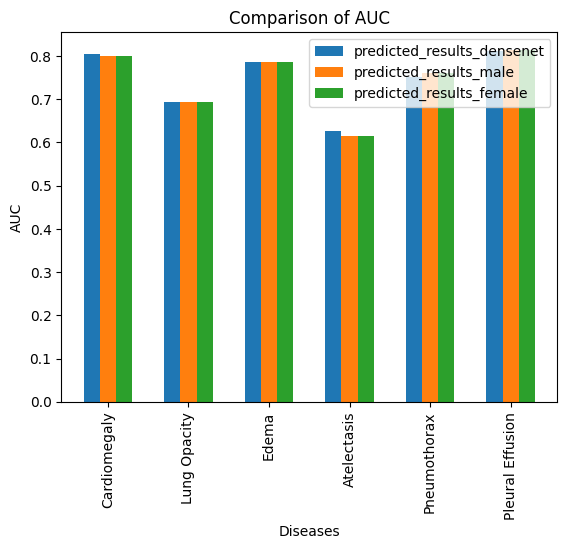

In [196]:

# Extract diseases and AUC values
diseases_to_plot = list(auc_general.keys())
values2 = [auc_general[disease] for disease in diseases_to_plot]
values_male = [auc_female[disease] for disease in diseases_to_plot]
values_female = [auc_female[disease] for disease in diseases_to_plot]

# Setting the positions and width for the bars
positions = np.arange(len(diseases_to_plot))
bar_width = 0.2

# Plotting the bars
fig, ax = plt.subplots()
bar2 = ax.bar(positions - bar_width, values2, width=bar_width, label='predicted_results_densenet')
bar3 = ax.bar(positions, values_male, width=bar_width, label='predicted_results_male')
bar4 = ax.bar(positions + bar_width, values_female, width=bar_width, label='predicted_results_female')


# Adding some text for labels, title, and axes ticks
ax.set_xlabel('Diseases')
ax.set_ylabel(met)
ax.set_title(f'Comparison of {met}')
ax.set_xticks(positions)
ax.set_xticklabels(diseases, rotation='vertical')  # Rotating labels vertically
ax.legend()

# Show the plot
plt.show()


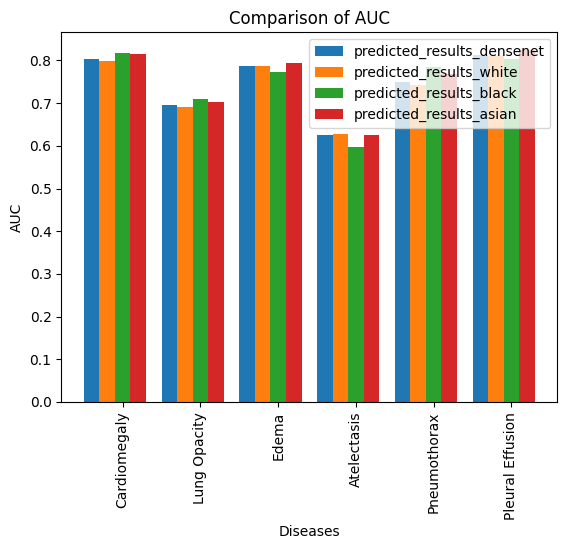

In [197]:

# Extract diseases and AUC values
diseases = list(auc_general.keys())
values2 = [auc_general[disease] for disease in diseases]
values_white = [auc_white[disease] for disease in diseases]
values_black = [auc_black[disease] for disease in diseases]
values_asian = [auc_asian[disease] for disease in diseases]

# Setting the positions and width for the bars
positions = np.arange(len(diseases))
bar_width = 0.2

# Plotting the bars
fig, ax = plt.subplots()
bar2 = ax.bar(positions - 2*bar_width, values2, width=bar_width, label='predicted_results_densenet')
bar3 = ax.bar(positions - bar_width, values_white, width=bar_width, label='predicted_results_white')
bar4 = ax.bar(positions, values_black, width=bar_width, label='predicted_results_black')
bar5 = ax.bar(positions + bar_width, values_asian, width=bar_width, label='predicted_results_asian')


# Adding some text for labels, title, and axes ticks
ax.set_xlabel('Diseases')
ax.set_ylabel(met)
ax.set_title(f'Comparison of {met}')
ax.set_xticks(positions)
ax.set_xticklabels(diseases, rotation='vertical')  # Rotating labels vertically
ax.legend()

# Show the plot
plt.show()
